In [55]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from functools import  partial
sys.path.insert(0, '/cluster/work/climate/dnikolo/n2o')
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config


In [56]:
from derivative import dxdt
from scipy.integrate import cumulative_trapezoid

Load data

In [57]:
config = read_config(
    '/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/config_half.yaml')

In [58]:
global global_rmse
global_rmse = config["Global_sqrt_mse"]


In [59]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)


class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]


def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key=lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    # return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)
    # return idxtopeak, sorted(peaks, key=lambda p: -p.born, reverse=True)
    return peaks


class Glaciation:
    def __init__(self, min_ind, max_ind, data, timestep=15):
        self.max = data[max_ind]
        self.min = data[min_ind]
        self.min_ind = min_ind
        self.max_ind = max_ind
        self.magnitude = self.max - self.min
        self.time = (max_ind - min_ind)*timestep
        self.timestep=timestep
    def estimate_glac_time(self,data ,max_rmse_diff=2 ):
        glac_timesteps=self.max_ind- self.min_ind
        if glac_timesteps ==1:
            self.linear=True
            time=self.timestep
            self.rate_arr=np.array([(self.max-self.min)/self.timestep*60])
            self.line_rmse=0
        else:
            #Calculate mean suqared error relative to a line between the two points
            linear_growth_line = np.linspace(data[self.min_ind],data[self.max_ind], num =glac_timesteps+1 )
            rmse = np.sqrt((np.square(linear_growth_line - data[self.min_ind:self.max_ind+1])).mean())
            self.line_rmse=rmse
            if rmse>max_rmse_diff*global_rmse:
                self.linear=False
                #This divide by 3 is the magic number that makes all the noise robust derivatives work
                magical_factor=3
                t=np.arange(len(data))/magical_factor
                #TODO: Correct min and max ind to min and max in filtered data
                dIFdt = dxdt(data, t, kind="trend_filtered", order=0, alpha=1e-2)
                trend_filtered_curve = data[0] + cumulative_trapezoid(dIFdt, t, initial=0)
                # self.find_nearest_peak(trend_filtered_curve)
                #Correct so that total delta is equal to measured magnitude
                dIFdt_glac = dIFdt[self.min_ind:self.max_ind+1]
                dIFdt_glac *= self.magnitude/(cumulative_trapezoid(dIFdt_glac, t[self.min_ind:self.max_ind+1], initial=0)[-1])

                #Factor *4/3 added: 4 to convert to hours  and 3 to correct for the factor added above
                dIFdt_glac *= 60/self.timestep/magical_factor
                #Not sure about min rate to take
                self.rate_arr=dIFdt_glac[dIFdt_glac>1e-2]
                # print(f"rmse = {rmse:03f}: Non-linear")
            else:
                # print(f"rmse = {rmse:03f}: Linear")
                self.linear=True
                self.rate_arr=np.full(glac_timesteps , (self.max-self.min)/(glac_timesteps*self.timestep)*60)
        self.avg_rate = self.rate_arr.mean()


def select_peaks(data, filt, significant_peak_tresh=0.2, glac_tresh=0.4):
    if not isinstance(data, (list, np.ndarray)):
        data = data['ice_frac_hist']
    if filt is not None:
        filt_data = np.array(filt(data))
    else:
        filt_data = np.array(data)
    peaks = get_persistent_homology(filt_data)
    prev_peak = Peak(0)
    glac_list = []
    for peak in peaks:
        if peak.born > prev_peak.born+1:
            if peak.get_persistence(filt_data) >= significant_peak_tresh:
                # local_min = data[prev_peak.born:peak.born].min()
                # print(f"{prev_peak.born},{peak.born}")
                inter_peak_data = filt_data[prev_peak.born:peak.born]
                local_min_ind = np.where(
                    inter_peak_data == inter_peak_data.min())[0][-1]
                local_min = inter_peak_data[local_min_ind]
                if filt_data[peak.born] - local_min >= glac_tresh:
                    glac_list.append(Glaciation(
                        prev_peak.born + local_min_ind, peak.born, filt_data))
                    glac_list[-1].estimate_glac_time(filt_data)
                    # print("a")
                prev_peak = peak
    return glac_list


def get_combined_cloud_df(config):
    t_deltas = config['t_deltas']
    agg_fact = config['agg_fact']
    min_temp_array, max_temp_array = config['min_temp_arr'], config['max_temp_arr']
    folder_name = f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"
    # Initialize an empty list to store the individual dataframes
    cloud_properties_df_list = []

    # Iterate over each temperature range
    for i in range(len(min_temp_array)):
        cloud_properties_df_list.append([])
        min_temp = min_temp_array[i]
        max_temp = max_temp_array[i]

        # Iterate over each pole
        for pole in config["pole_folders"]:
            # Construct the file path
            fp = os.path.join(
                config['postprocessing_output_dir'],
                pole,
                folder_name,
                f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
            )

            # Read the parquet file into a dataframe
            df = pd.read_parquet(fp)

            # Add columns for min_temp, max_temp, and pole
            df['min_temp'] = min_temp
            df['max_temp'] = max_temp
            df['pole'] = pole
            df['Hemisphere'] = "South" if pole == "sp" else "North"
            df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
            df["Radius [km]"]=np.sqrt(df["avg_size[km]"]/np.pi)
            # Append the dataframe to the sublist
            cloud_properties_df_list[i].append(df)

    # Combine all dataframes into a single dataframe
    return pd.concat(
        [df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)


def extract_glaciation_events(df):
    out_df = df[df["max_ice_fraction"]-(1-df["max_water_frac"]) > 0.5].copy()
    part_select_peaks = partial(select_peaks, filt=None)
    out_df["glac_list"] = df.apply(part_select_peaks, axis=1)
    return out_df


def gen_glac_df(result_df, combined_cloud_df):
    glaciations_list = []
    for i, row in result_df.iterrows():
        for glaciation in row['glac_list']:
            # glaciation.
            glaciations_list.append([i, glaciation.time, glaciation.magnitude, glaciation.min_ind , glaciation.max_ind, glaciation.linear, glaciation.line_rmse, glaciation.rate_arr,glaciation.rate_arr.mean() ])
    glaciations_df = pd.DataFrame(glaciations_list, columns=[
        "Cloud_ID", "Time [m]", "Magnitude", "Glac_start_ind", "Glac_peak_ind", "Linear", "line_rmse", "Rate_arr", "Mean_glac_rate"])
    glaciations_df["Glaciation time [h]"] = glaciations_df["Time [m]"]/60
    return pd.merge(glaciations_df, combined_cloud_df, how="left",
                    left_on="Cloud_ID", right_index=True, validate="m:1")


def save_glac_df(glaciations_df, config):
    for pole in config["pole_folders"]:
        output_dir = os.path.join(
            config['postprocessing_output_dir'], pole,
            config['time_folder_name'],
            f"Agg_{config['agg_fact']:02}_Glaciations"
        )
        # Save DataFrame to Parquet
        output_dir_parq = output_dir + ".parquet"
        print("Writing to ", output_dir_parq)
        glaciations_df.to_parquet(output_dir_parq)

        # Optionally save as CSV
        if config['write_csv']:
            output_dir_csv = output_dir + ".csv"
            glaciations_df.to_csv(output_dir_csv)



In [60]:
combined_cloud_df = get_combined_cloud_df(config)

(0.0, 100.0)

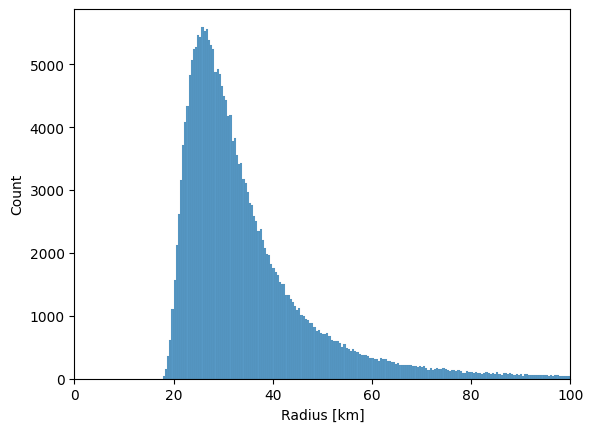

In [61]:
sns.histplot(combined_cloud_df["Radius [km]"])

plt.xlim(0,100)

In [62]:
#combined_cloud_df = get_combined_cloud_df(config)
result_df = extract_glaciation_events(combined_cloud_df)

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-03, tolerance: 2.864e-05
  model = cd_fast.enet_coordinate_descent(
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.870e-01, tolerance: 2.150e-04
  model = cd_fast.enet_coordinate_descent(
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

In [63]:
# for i, row in result_df.iloc[:50].iterrows():
#     for glac in row.glac_list:
#         glac.estimate_glac_time(np.array(row["ice_frac_hist"]))

In [64]:
glaciations_df = gen_glac_df(result_df, combined_cloud_df)

In [65]:
save_glac_df(glaciations_df, config)

Writing to  /cluster/work/climate/dnikolo/Cloud_analysis/np/20230116.0000_20230131.2345/Agg_03_Glaciations.parquet
Writing to  /cluster/work/climate/dnikolo/Cloud_analysis/sp/20230116.0000_20230131.2345/Agg_03_Glaciations.parquet


In [66]:
output_dir = os.path.join(
    config['postprocessing_output_dir'], "np",
    config['time_folder_name'],
    f"Agg_{config['agg_fact']:02}_Glaciations"
)

# Save DataFrame to Parquet
output_dir_parq = output_dir + ".parquet"
if os.path.isfile(output_dir_parq):
    print("Glaciations file exists")
    combined_cloud_df = get_combined_cloud_df(config)
    glaciations_df = pd.read_parquet(output_dir_parq)
    glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")
else:
    print("Glaciations file desn't exist")
    sqrt_mse = config["Global_sqrt_mse"]
    combined_cloud_df = get_combined_cloud_df(config)
    result_df = extract_glaciation_events(combined_cloud_df)
    glaciations_df = gen_glac_df(result_df, combined_cloud_df)
    save_glac_df(glaciations_df, config)
    glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")

Glaciations file exists


In [67]:
sqrt_mse = 0.05628526744657018
ice_cont_crit_frac = 0.05

Load data

In [68]:
sample_df_3 = combined_cloud_df.sample(1000, random_state=2)
sample_df_3 = sample_df_3[sample_df_3["max_ice_fraction"]-(1-sample_df_3["max_water_frac"])>0.9]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


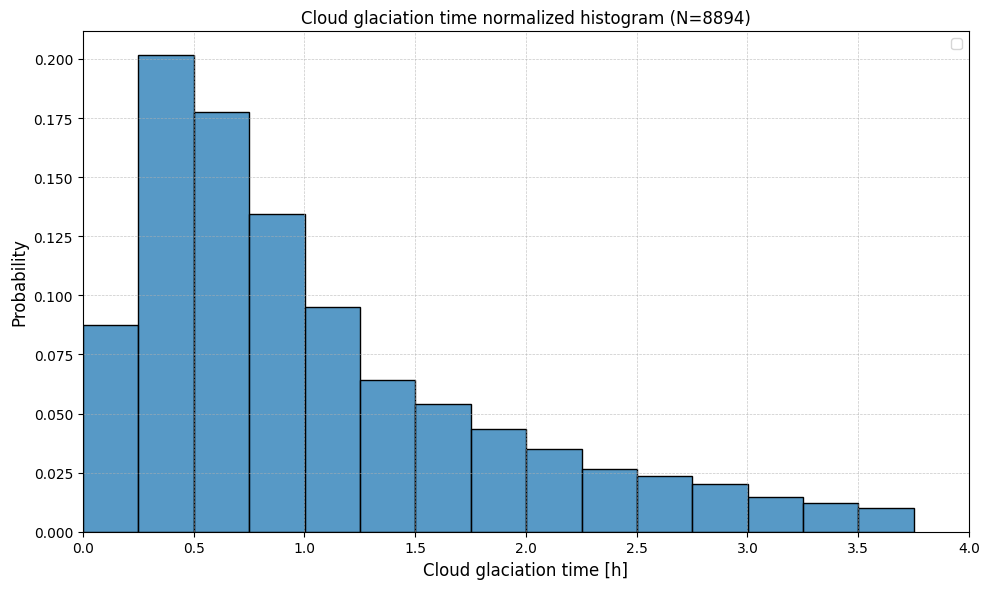

In [69]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",bins=bins,stat="probability",)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df)})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/CGT_stistics.png",dpi=400)

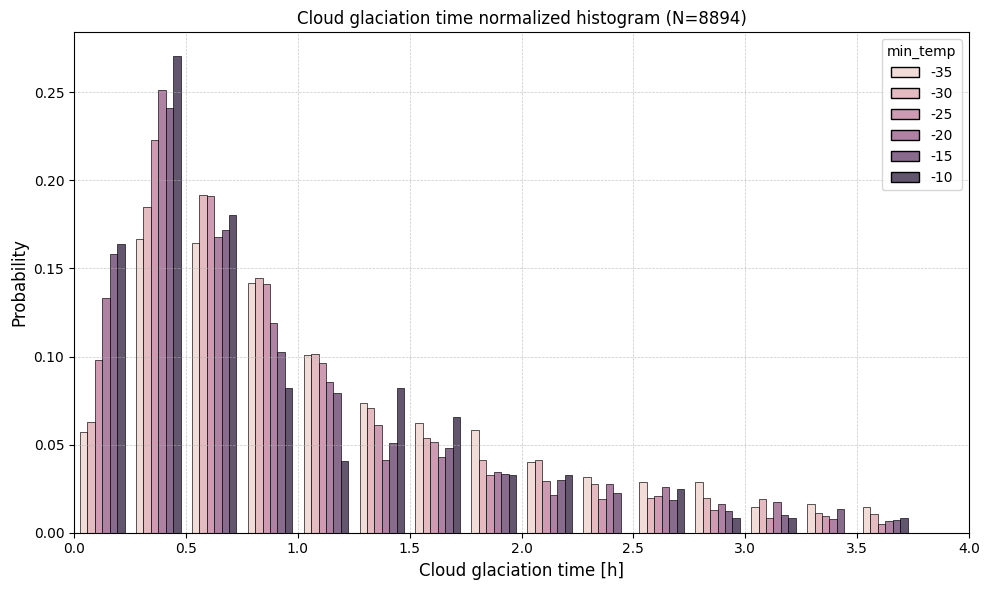

In [88]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",multiple="dodge", hue='min_temp',common_norm=False,bins=bins,stat="probability",shrink=0.8)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
# ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# plt.tight_layout()
# plt.legend()
plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df)})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/CGT_stistics.png",dpi=400)

<Axes: xlabel='Glaciation time [h]', ylabel='Probability'>

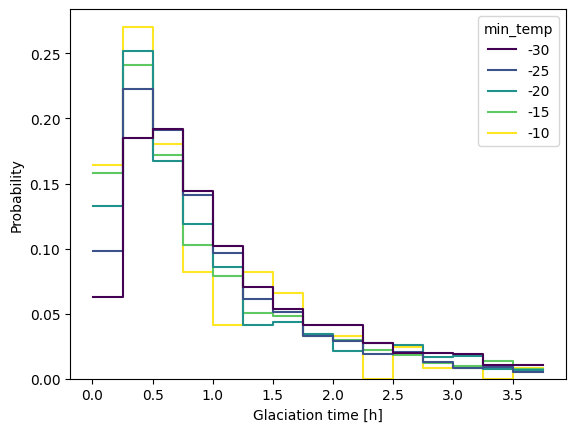

In [89]:
sns.histplot(data=glaciations_df[glaciations_df["min_temp"]>=-30], x="Glaciation time [h]",element="step",fill=False, hue='min_temp',common_norm=False,bins=bins,stat="probability",palette="viridis")


In [71]:
glaciations_df.min_temp

0      -10
1      -10
2      -10
3      -10
4      -10
        ..
8889   -35
8890   -35
8891   -35
8892   -35
8893   -35
Name: min_temp, Length: 8894, dtype: int64

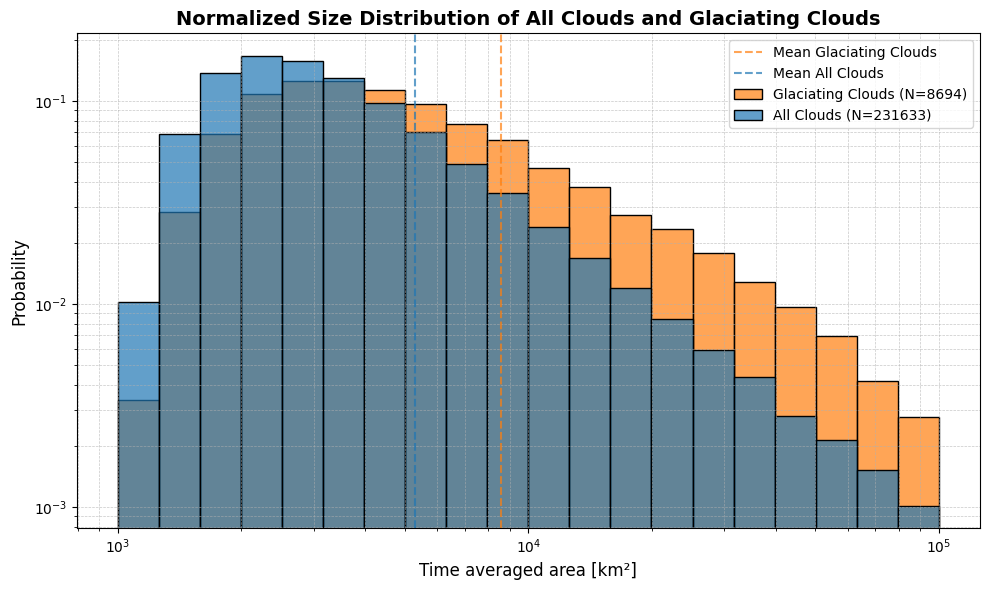

In [100]:

# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_cloud_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds)})",
    alpha=0.7  # Slight transparency for overlap visibility
)

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df)})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
filename = "/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Size_hist_all_vs_glac_normalized"
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

TypeError: unsupported operand type(s) for &: 'float' and 'bool'

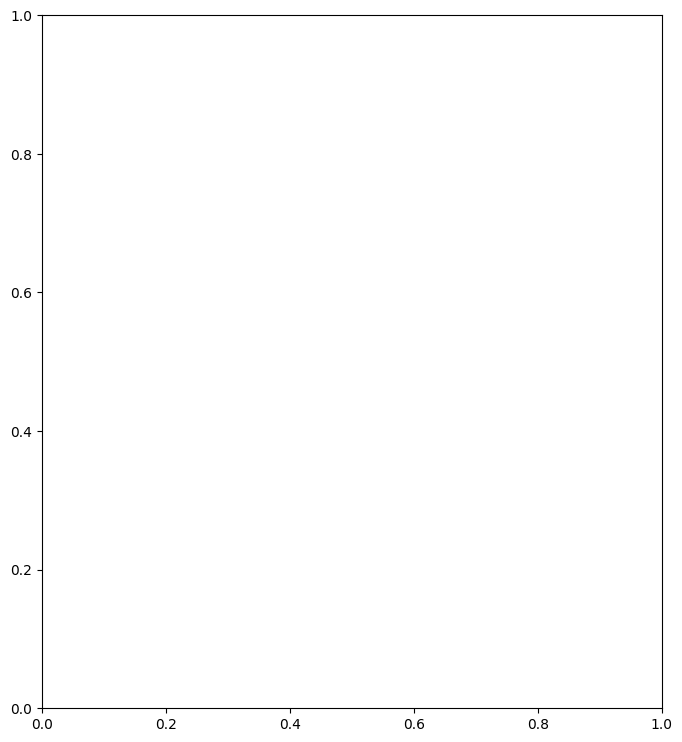

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exponents = np.linspace(3, 6, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
lifetime_thresholds = [1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(8, 9))

for lifetime_thresh in lifetime_thresholds:
    bin_counts = pd.cut(
        combined_cloud_df[
            (combined_cloud_df["avg_size[km]"] > 2000) & (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["avg_size[km]"], bins
    ).value_counts(sort=False)
    
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df = new_df[new_df["bin_counts"].idxmax():]
    new_df = new_df.iloc[1:-1]
    
    coef = np.polyfit(x=new_df["center"], y=np.log(new_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    
    ax.scatter(new_df["center"], np.log(new_df["bin_counts"]), label=f'Lifetime>{lifetime_thresh}h β={coef[0]:.02f}')
    ax.plot(new_df["center"], poly1d_fn(new_df["center"]))

ax.set_xlabel("Size [km]")
ax.set_ylabel("Log(Bin Counts)")
ax.legend()
plt.show()


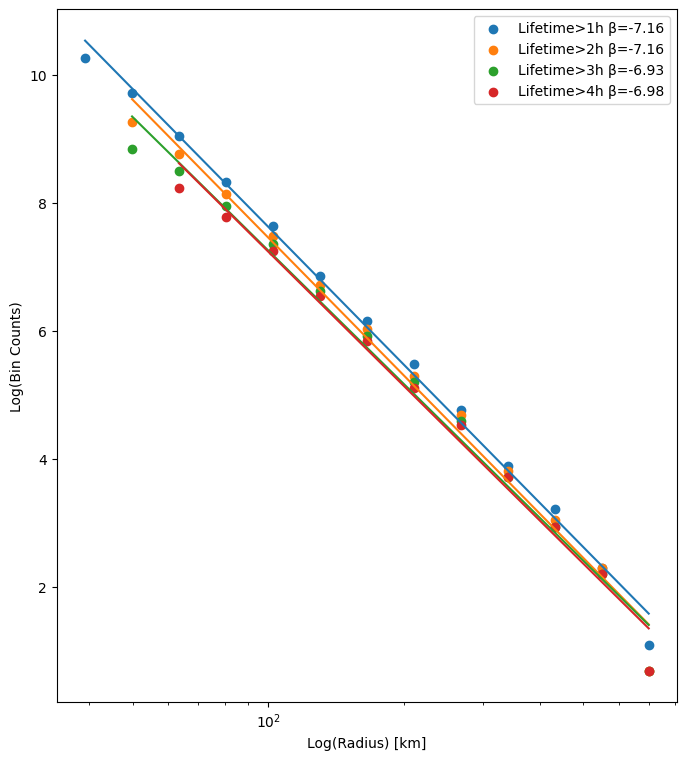

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exponents = np.linspace(0.5, 3, 25)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
lifetime_thresholds = [1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(8, 9))

for lifetime_thresh in lifetime_thresholds:
    bin_counts = pd.cut(
        combined_cloud_df[ (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["Radius [km]"], bins
    ).value_counts(sort=False)
    
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df = new_df[new_df["bin_counts"].idxmax():]
    new_df = new_df.iloc[1:-1]
    
    coef = np.polyfit(x=new_df["center"], y=np.log(new_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    
    ax.scatter(np.power(10,new_df["center"]), np.log(new_df["bin_counts"]), label=f'Lifetime>{lifetime_thresh}h β={coef[0]:.02f}')
    ax.plot(np.power(10,new_df["center"]), poly1d_fn(new_df["center"]))

ax.set_xlabel("Log(Radius) [km]")
ax.set_ylabel("Log(Bin Counts)")
ax.set_xscale("log")
ax.legend()
plt.show()


array([-2.99415619, 20.0543836 ])

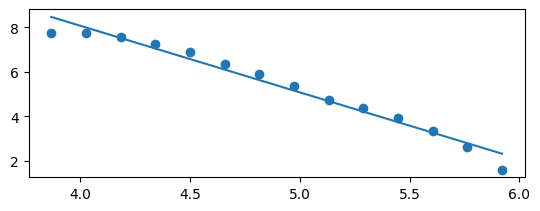

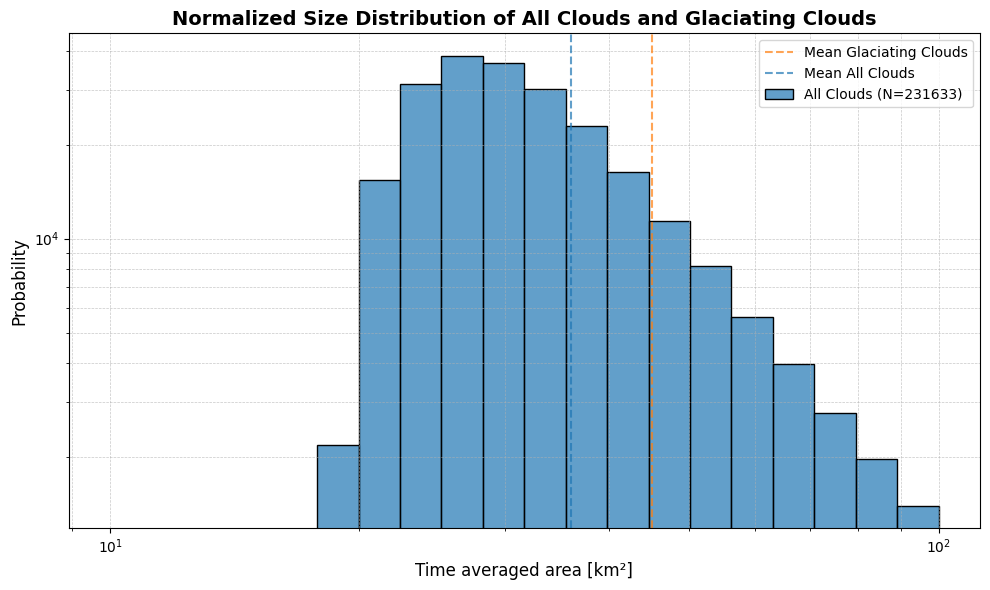

In [99]:

# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['Radius [km]'].mean()
mean_combined = combined_cloud_df['Radius [km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# # Plot histograms
# sns.histplot(
#     data=glaciating_clouds,
#     ax=ax,
#     x="Radius [km]",
#     log_scale=(True, False),
#     binrange=(3, 5),
#     bins=20,
#     color=sns.color_palette()[1],
#     stat="probability",
#     label=f"Glaciating Clouds (N={len(glaciating_clouds)})",
#     alpha=0.7  # Slight transparency for overlap visibility
# )

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(1, 2),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df)})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
# filename = "/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Size_hist_all_vs_glac_normalized"
# plt.savefig(filename + ".pdf", dpi=400)
# plt.savefig(filename + ".png", dpi=400)

In [78]:
# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_cloud_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds)})",
    alpha=0.7  # Slight transparency for overlap visibility
)

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(0, 5),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df)})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
filename = "/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Size_hist_all_vs_glac_normalized"
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x14b80bbcf600> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>

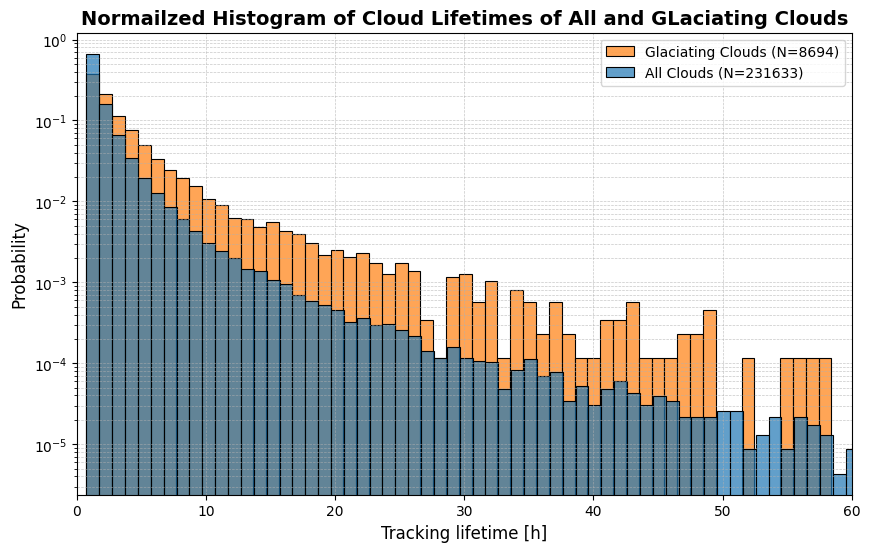

In [73]:
mean_glaciating = glaciating_clouds['Lifetime [h]'].mean()
mean_combined = combined_cloud_df['Lifetime [h]'].mean()

# Plotting
plt.figure(figsize=(10, 6))

sns.histplot(data=glaciating_clouds, x="Lifetime [h]",binwidth=1,log_scale=[False, True],color=sns.color_palette()[1], edgecolor='black', linewidth=0.8, stat="probability", alpha=0.7,label= f"Glaciating Clouds (N={len(glaciating_clouds)})")
sns.histplot(data=combined_cloud_df, x="Lifetime [h]",binwidth=1,log_scale=[False, True],color=sns.color_palette()[0], edgecolor='black', linewidth=0.8, stat="probability",alpha=0.7, label=f"All Clouds (N={len(combined_cloud_df)})",)
# plt.legend(title='Hemisphere', loc='upper right', labels=['North', 'South'])
# Labels and title
plt.xlabel("Tracking lifetime [h]", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Normailzed Histogram of Cloud Lifetimes of All and GLaciating Clouds", fontsize=14, fontweight='bold')

# Customize x-axis
# plt.xlim(1e3, 1e6)
plt.yscale('log')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
# Ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(left=0, right=60)
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/Lifetime_hist_all_vs_glac_normalized"
plt.savefig(filename+".pdf",dpi=400)
plt.savefig(filename+".png",dpi=400)

In [74]:
combined_cloud_df.keys()

Index(['is_liq', 'is_mix', 'is_ice', 'max_water_frac', 'max_ice_fraction',
       'avg_size[km]', 'max_size[km]', 'min_size[km]', 'avg_size[px]',
       'max_size[px]', 'min_size[px]', 'track_start_time', 'track_length',
       'glaciation_start_time', 'glaciation_end_time', 'avg_lat', 'avg_lon',
       'start_ice_fraction', 'end_ice_fraction', 'ice_frac_hist', 'lat_hist',
       'lon_hist', 'size_hist_km', 'min_temp', 'max_temp', 'pole',
       'Hemisphere', 'Lifetime [h]', 'Radius [km]'],
      dtype='object')

/cluster/work/climate/dnikolo/dump/ipykernel_994951/2897791896.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_ranges, y=occurrence_rate.values, palette="coolwarm")  # Use a color palette for aesthetics


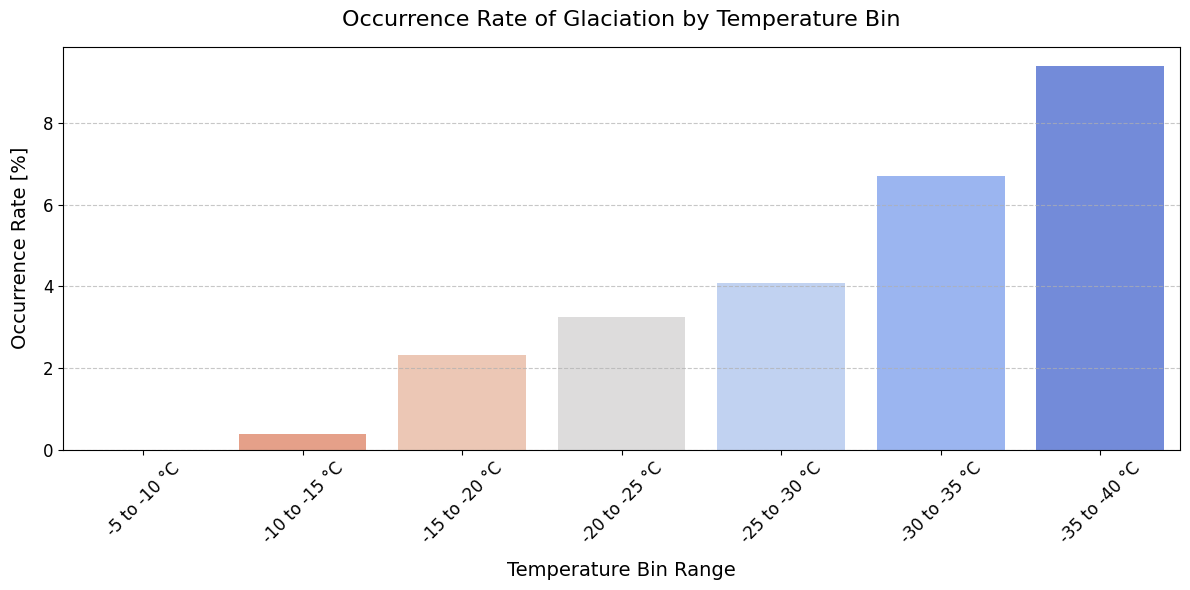

In [75]:
# Calculate occurrence rate
occurrence_rate = glaciating_clouds["min_temp"].value_counts() / combined_cloud_df["min_temp"].value_counts()*100

# Create bin ranges
bin_ranges = [f"{int(temp)} to {int(temp - 5)} °C" for temp in occurrence_rate.index]

# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size for better visual appeal
sns.barplot(x=bin_ranges, y=occurrence_rate.values, palette="coolwarm")  # Use a color palette for aesthetics

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines only on the y-axis with dashed lines

# Labeling
plt.xlabel("Temperature Bin Range", fontsize=14, labelpad=10)  # Font size and padding for x-label
plt.ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)  # Font size and padding for y-label
plt.title("Occurrence Rate of Glaciation by Temperature Bin", fontsize=16, pad=15)  # Add a title
plt.xticks(fontsize=12, rotation=45)  # Rotate x-ticks for better readability if needed
plt.yticks(fontsize=12)  # Adjust y-tick font size

# Invert x-axis
plt.gca().invert_xaxis()  # Invert the direction of the x-axis

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



In [76]:
combined_cloud_df["Cloud_ID"].value_counts()

KeyError: 'Cloud_ID'

In [ ]:
glaciations_df["min_temp"].value_counts()

In [ ]:
glaciations_df["min_temp"].unique()

array([-10, -15, -20, -25, -30, -35])

In [ ]:
bins = numpy.linspace(0, 1, 10)
digitized = numpy.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]
for min_temp in glaciations_df["min_temp"].unique():
    group = glaciations_df[glaciations_df["min_temp"]=min_temp]
    for i,row in group.iterrows():
        np.round(row["Rate_arr"])

-10
-15
-20
-25
-30
-35


In [ ]:
glaciations_df['Glaciation time [h]'].corr(glaciations_df['Lifetime [h]'])

0.5295992766272223